### One-class classification

To demonstrate how to implement network models in one-class classification, we will use the IMDb (Internet Movies Database) movie review library, which is also available at the following links: https://www.imdb.com/interfaces/ or https://www.kaggle.com/lakshmi25npathi/datasets. In this dataset, we find $50000$ movie reviews that are classified into one of two classes, i.e. positive or negative review. Moreover, this set was divided into a training set ($25000$ reviews) and a test set ($25000$ reviews). In each subset we have exactly half of positive and negative reviews.

#### Prepare input data

The IMDb collection is included with the Keras package and has been prepared for direct use, i.e. textual reviews have been converted into vectors of integers, with each number representing a word number (index) key in the dictionary. Additionally, each input vector is assigned a label of $0$ or $1$, which indicates a negative or positive review, respectively.

In [2]:
from tensorflow.keras.datasets import imdb
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

# a number of keywords
L=100
# download training and testing datasets limited to L keywords
(train_data,train_labels),(test_data,test_labels)=imdb.load_data(num_words=L+4)
N=len(train_data)
print('The number of training samples:',N)

The number of training samples: 25000


The imdb.load_data function accepts an argument specifying the number of keywords (the first $L$ most frequently occurring) to be taken into account (the value $L+4$ was entered because the index $0$ is used to complete the vector, $1$ means the start of the review text , $2$ means a word that does not appear in the dictionary, $3$ is not used). The $N$ variable (**N=len(train_data)**) specifies the number of data vectors in the training set. Below is an example input vector describing a sample review with a maximum of $15$ of keywords.

In [3]:
print('Exemplary review:')
print(train_data[0])

Exemplary review:
[1, 14, 22, 16, 43, 2, 2, 2, 2, 65, 2, 2, 66, 2, 4, 2, 36, 2, 5, 25, 100, 43, 2, 2, 50, 2, 2, 9, 35, 2, 2, 5, 2, 4, 2, 2, 2, 2, 2, 2, 39, 4, 2, 2, 2, 17, 2, 38, 13, 2, 4, 2, 50, 16, 6, 2, 2, 19, 14, 22, 4, 2, 2, 2, 4, 22, 71, 87, 12, 16, 43, 2, 38, 76, 15, 13, 2, 4, 22, 17, 2, 17, 12, 16, 2, 18, 2, 5, 62, 2, 12, 8, 2, 8, 2, 5, 4, 2, 2, 16, 2, 66, 2, 33, 4, 2, 12, 16, 38, 2, 5, 25, 2, 51, 36, 2, 48, 25, 2, 33, 6, 22, 12, 2, 28, 77, 52, 5, 14, 2, 16, 82, 2, 8, 4, 2, 2, 2, 15, 2, 4, 2, 7, 2, 5, 2, 36, 71, 43, 2, 2, 26, 2, 2, 46, 7, 4, 2, 2, 13, 2, 88, 4, 2, 15, 2, 98, 32, 2, 56, 26, 2, 6, 2, 2, 18, 4, 2, 22, 21, 2, 2, 26, 2, 5, 2, 30, 2, 18, 51, 36, 28, 2, 92, 25, 2, 4, 2, 65, 16, 38, 2, 88, 12, 16, 2, 5, 16, 2, 2, 103, 32, 15, 16, 2, 19, 2, 32]


This way of representing data is not directly suitable for training a neural network model. First of all, it should be noted that each input vector describing a single review may have a different size. Therefore, a process of preparing input data for the neural network training process is required. Since the number of keywords is strictly defined,
then we have at least two possibilities here: (I) for each review we can create a vector of length $L$ elements and mark the occurrence of specific keywords with the values $1$, where the keywords are represented by the indexes of the elements in the vector, (II) similarly to the case of (I ), but this time we can count the occurrences of specific words.

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer

def prepare_data(name,data,labels):
    tfidf_vectorizer = TfidfVectorizer(max_features=L)
    x_tfidf = tfidf_vectorizer.fit_transform([" ".join(map(str, review)) for review in data])

    # Normalize the TF-IDF vectors
    x_tfidf_normalized = x_tfidf / np.linalg.norm(x_tfidf, axis=1, keepdims=True)

    # Save TF-IDF data and labels
    np.save(name + '_data.npy', x_tfidf_normalized)
    np.save(name + '_labels.npy', labels)
    
prepare_data('train',train_data,train_labels)
prepare_data('test',test_data,test_labels)
    # Convert reviews to TF-IDF representation
    # tfidf_vectorizer = TfidfVectorizer(max_features=L)
    # train_data = tfidf_vectorizer.fit_transform([" ".join(map(str, review)) for review in train_data])
    # # train_labels = tfidf_vectorizer.fit_transform([" ".join(map(str, review)) for review in train_labels])
    # test_data = tfidf_vectorizer.transform([" ".join(map(str, review)) for review in test_data])
    # # test_labels = tfidf_vectorizer.transform([" ".join(map(str, review)) for review in test_labels])


In [4]:
def prepare_data(name,data,labels):
    global N,L

    x=np.zeros((N,L),float)
    y=np.zeros((N,1),float)
    for i in range(0,N):
        for j in data[i]:
            # here we can decide, wether we want to count or indicate the occurences of words
            # =1 allows to indicate the occurence of a specific words
            # +=1 allows to count the numbers of occurrences
            x[i][j-4]=1
        # we use normalization in case of counting words
        x[i]/=np.linalg.norm(x[i])
        y[i]=labels[i]
    np.save(name+'_data.npy',x)
    np.save(name+'_labels.npy',y)
    
    return

# preparation of input data
prepare_data('train',train_data,train_labels)
prepare_data('test',test_data,test_labels)

Of course, it is possible to recreate individual reviews through a reverse mapping process, i.e. keyword-to-keyword index.

In [5]:
def decode_data(data):

    dictionary=imdb.get_word_index()
    my_dictionary=dict([(k,v) for (v,k) in dictionary.items()])
    s=' '.join([my_dictionary.get(d-3,'?') for d in data])
    return s

print(decode_data(train_data[0]))

? this film was just ? ? ? ? story ? ? really ? the ? they ? and you could just ? ? there ? ? is an ? ? and ? the ? ? ? ? ? ? from the ? ? ? as ? so i ? the ? there was a ? ? with this film the ? ? ? the film were great it was just ? so much that i ? the film as ? as it was ? for ? and would ? it to ? to ? and the ? ? was ? really ? at the ? it was so ? and you ? what they ? if you ? at a film it ? have been good and this ? was also ? to the ? ? ? that ? the ? of ? and ? they were just ? ? are ? ? out of the ? ? i ? because the ? that ? them all ? up are ? a ? ? for the ? film but ? ? are ? and ? be ? for what they have ? don't you ? the ? story was so ? because it was ? and was ? ? after all that was ? with ? all


The next step is to divide the test set into two parts, i.e. one used for testiung and the other serving as a validation set. In our example, we divide it in half.

In [6]:
train_x=np.load('train_data.npy')
train_y=np.load('train_labels.npy')
test_x=np.load('test_data.npy')
test_y=np.load('test_labels.npy')
N=len(test_x)
N2=N//2
(test_x,validate_x)=(test_x[0:N2],test_x[N2:N])
(test_y,validate_y)=(test_y[0:N2],test_y[N2:N])
print('Exemplary vector discribing one review:')
print(np.round(test_x[0],3))

Exemplary vector discribing one review:
[0.204 0.204 0.204 0.204 0.204 0.204 0.204 0.    0.    0.204 0.204 0.
 0.204 0.    0.    0.    0.    0.    0.    0.204 0.    0.204 0.    0.204
 0.204 0.204 0.    0.204 0.204 0.    0.    0.    0.    0.    0.204 0.
 0.    0.    0.    0.    0.    0.    0.204 0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.204 0.    0.    0.204 0.    0.    0.    0.    0.    0.    0.
 0.204 0.204 0.204 0.   ]


#### Construction of a neural network model

In the binary classification task under consideration, the input of the neural network is vectors of size $L$-elements ($L$ is the number of the most important keywords), while the output is one value from the range $[0,1]$, which determines the affiliation to one of two classes. A value of $1$ indicates a positive review. In turn, the value $0$ is a negative review.

In our example study, we will use a network with one layer and the number of $1$ neuron.

In [12]:
# neural network - building the model
model=tf.keras.models.Sequential()
# model.add(tf.keras.layers.Embedding(N, 16))
# model.add(tf.keras.layers.GlobalAveragePooling1D())
model.add(tf.keras.layers.Dense(32,activation='relu'))
model.add(tf.keras.layers.Dense(1,activation='sigmoid'))

model.build(input_shape=(N,L))
# model.compile(optimizer='Adam',loss=tf.keras.losses.MeanSquaredError(),metrics=['accuracy'])
model.compile(optimizer='Adam', loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (25000, 32)               3232      
                                                                 
 dense_4 (Dense)             (25000, 1)                33        
                                                                 
Total params: 3265 (12.75 KB)
Trainable params: 3265 (12.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


We carry out the training process taking into account the validation set.

In [13]:
# siec neuronowa - trenowanie modelu
history=model.fit(train_x,train_y,epochs=100,batch_size=100,validation_data=(validate_x,validate_y))
tf.keras.models.save_model(model,'model_1.h5')

Epoch 1/100
250/250 [==============================] - 3s 6ms/step - loss: 0.6423 - accuracy: 0.6531 - val_loss: 0.5964 - val_accuracy: 0.6939
Epoch 2/100
250/250 [==============================] - 1s 4ms/step - loss: 0.5794 - accuracy: 0.7006 - val_loss: 0.5661 - val_accuracy: 0.7061
Epoch 3/100
250/250 [==============================] - 1s 4ms/step - loss: 0.5669 - accuracy: 0.7047 - val_loss: 0.5623 - val_accuracy: 0.7085
Epoch 4/100
250/250 [==============================] - 1s 4ms/step - loss: 0.5639 - accuracy: 0.7083 - val_loss: 0.5587 - val_accuracy: 0.7129
Epoch 5/100
250/250 [==============================] - 1s 4ms/step - loss: 0.5632 - accuracy: 0.7059 - val_loss: 0.5583 - val_accuracy: 0.7130
Epoch 6/100
250/250 [==============================] - 1s 4ms/step - loss: 0.5624 - accuracy: 0.7064 - val_loss: 0.5579 - val_accuracy: 0.7128
Epoch 7/100
250/250 [==============================] - 1s 4ms/step - loss: 0.5618 - accuracy: 0.7076 - val_loss: 0.5589 - val_accuracy: 0.7122

C:\Users\Toshiba\AppData\Local\Temp\ipykernel_5500\814429872.py:3: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model,'model_1.h5')


After training, we save our model (weights and network structure) to a file with the ".h5" extension using the save_model() function. Such a model can then be repeatedly loaded into memory and used in a classification task without the need for retraining.

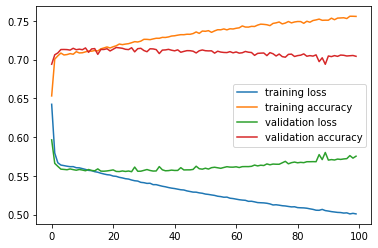

In [14]:
plt.plot(history.history['loss'])
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_loss'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training loss','training accuracy','validation loss','validation accuracy'])
plt.show()

It should be noted here that the fit() function returns the loss function and metric values calculated for each epoch of the training process in the form of a tensor.

We can use the trained model in practice in the following way:

In [15]:
# we use the trained model for classification of one vector (review)
model=tf.keras.models.load_model('model_1.h5')
print(model.predict(test_x[0:1])[0][0])

1/1 [==============================] - 0s 174ms/step
0.3944836


We can evaluate the classification for the entire test set using the evaluate() function:

In [16]:
# we test our model for the whole test set
model=tf.keras.models.load_model('model_1.h5')
val=model.evaluate(test_x,test_y)
print('Accuracy:',np.round(100*val[1],2),'%')

391/391 [==============================] - 1s 3ms/step - loss: 0.5897 - accuracy: 0.6990
Accuracy: 69.9 %


---

Increasing the Number of Keywords:
Observation: Increasing the number of keywords positively impacted the learning process, leading to a higher accuracy.
Recommendation: This suggests that a more extensive vocabulary representation may capture more nuanced information from reviews.
Changing the Way of Representation of Text Data:

Observation: You didn't specify how you changed the representation, but it's essential to experiment with different text representation techniques.
Recommendation: Try approaches like TF-IDF, word embeddings (e.g., Word2Vec, GloVe), or more advanced techniques like BERT embeddings.

Increasing the Number of Hidden Layers:
Observation: Increasing the number of hidden layers and neurons had a positive impact on both the learning process and the final results.
Recommendation: This indicates that a more complex network architecture with more layers can capture more intricate patterns. Be cautious of overfitting, and consider regularization techniques.

Modifying (Increasing, Decreasing) the Number of Neurons:
Observation: Adjusting the number of neurons had an impact on the classification results.
Recommendation: Experiment further with different neuron configurations to find the right balance between model complexity and generalization.

Replacing Loss Function from Binary Crossentropy to MSE:
Observation: Drastic changes did not significantly impact the effectiveness of the model.
Recommendation: It's common for classification tasks to use binary crossentropy. MSE is often used in regression tasks. Stick to binary crossentropy for classification problems unless you have specific reasons to use MSE.

Converting the ReLU Activation Function into Sigmoid:
Observation: Changing activation functions had some impact on accuracy.
Recommendation: Experimenting with different activation functions is a good practice. Sigmoid is commonly used in the output layer for binary classification, but ReLU is often used in hidden layers. Consider experimenting with both to find the optimal combination.

Additional Recommendations:
Learning Rate and Optimizer: Experiment with different learning rates and optimizers (e.g., Adam, SGD) to find the most effective combination for your task.
Batch Size: Adjusting the batch size can also have an impact on the learning process. Experiment with different batch sizes to find the optimal one.
Early Stopping: Implement early stopping to prevent overfitting and find the point where the model generalizes well.
Regularization: Consider using dropout or other regularization techniques to prevent overfitting, especially with deeper architectures.